# Сегментация радионуклидных изображений печени

### Импорты

In [1]:
import os
import random
from os.path import join as pjoin
import albumentations
import numpy as np
import torch
from PIL import Image
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
from dataset import CustomDataset
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from train import (
    CheckpointSaver,
    load_checkpoint,
    train,
)
from unet import UNet
from metric import MeanIoU
from loss import DiceLoss

### Установка начального значения генераторов случайных чисел

In [2]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)
seed_everything(42, torch_deterministic=False)

### Преобразования изображений (аугментации)

In [3]:
IMAGE_SIZE = 256
transforms = albumentations.Compose(
    [
        albumentations.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        ToTensorV2(),
    ]
)

### Примеры радионуклидных ихображений печени и соответсвующих им масок

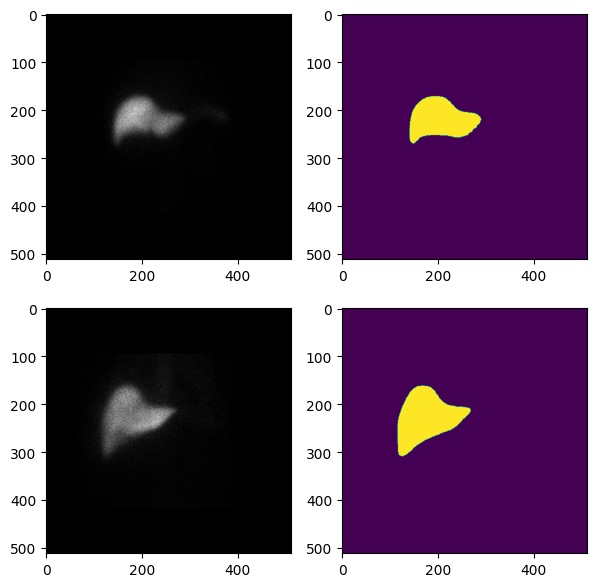

In [4]:
image1 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/images/image (2).png")
mask1 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/masks/mask_image (2).png")
image2 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/images/image (3).png")
mask2 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/masks/mask_image (3).png")
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].imshow(image1)
ax[0, 1].imshow(mask1)
ax[1, 0].imshow(image2)
ax[1, 1].imshow(mask2)

### Разделение датасета на тренировочный, валидационный и тестовый (70/20/10)

In [5]:
full_dataset = CustomDataset(root_dir="C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data",transforms = transforms)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print('Количество изображений в полном датасете:',len(full_dataset))
print('Количество изображений в тренировочном датасете:',len(train_dataset))
print('Количество изображений в валидационном датасете:',len(val_dataset))
print('Количество изображений в тестовом датасете:',len(test_dataset))


Количество изображений в полном датасете: 30
Количество изображений в тренировочном датасете: 21
Количество изображений в валидационном датасете: 6
Количество изображений в тестовом датасете: 3


### Настройка гиперпараметров

In [6]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_WORKERS = 2
EPOCH_NUM = 20
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Создание модели

In [7]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

model = UNet(in_channels=3, out_channels=1)

loss_fn = DiceLoss()
metric_fn = MeanIoU()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=5, gamma=0.8
) #уменьшение скорости обучения

### Подготовка модели, данных и оптимизатора к обучению

In [8]:
accelerator = Accelerator(cpu=False, mixed_precision="fp16")
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="DICE",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

### Обучение модели

In [9]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------
Epoch 0/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.87485
Epoch train metric: 0.24082


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.89771
Epoch validation metric: 0.03882
Best epoch DICE value is 0.0388 on 0 epoch
------------------------------
Epoch 1/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.82348
Epoch train metric: 0.41979


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.87009
Epoch validation metric: 0.51686
Best epoch DICE value is 0.5169 on 1 epoch
------------------------------
Epoch 2/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.80409
Epoch train metric: 0.53002


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.84184
Epoch validation metric: 0.65481
Best epoch DICE value is 0.6548 on 2 epoch
------------------------------
Epoch 3/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.78399
Epoch train metric: 0.60774


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.80832
Epoch validation metric: 0.66247
Best epoch DICE value is 0.6625 on 3 epoch
------------------------------
Epoch 4/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.77915
Epoch train metric: 0.61224


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.78193
Epoch validation metric: 0.71762
Best epoch DICE value is 0.7176 on 4 epoch
------------------------------
Epoch 5/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.76915
Epoch train metric: 0.67459


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.77093
Epoch validation metric: 0.71484
Best epoch DICE value is 0.7176 on 4 epoch
------------------------------
Epoch 6/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.76165
Epoch train metric: 0.68308


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.76802
Epoch validation metric: 0.77312
Best epoch DICE value is 0.7731 on 6 epoch
------------------------------
Epoch 7/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.76168
Epoch train metric: 0.70321


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.77254
Epoch validation metric: 0.78656
Best epoch DICE value is 0.7866 on 7 epoch
------------------------------
Epoch 8/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.75549
Epoch train metric: 0.73387


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.76967
Epoch validation metric: 0.76844
Best epoch DICE value is 0.7866 on 7 epoch
------------------------------
Epoch 9/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.75503
Epoch train metric: 0.74995


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.75790
Epoch validation metric: 0.76814
Best epoch DICE value is 0.7866 on 7 epoch
------------------------------
Epoch 10/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.74886
Epoch train metric: 0.75877


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.75933
Epoch validation metric: 0.84094
Best epoch DICE value is 0.8409 on 10 epoch
------------------------------
Epoch 11/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.75098
Epoch train metric: 0.76787


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.75775
Epoch validation metric: 0.85628
Best epoch DICE value is 0.8563 on 11 epoch
------------------------------
Epoch 12/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.74302
Epoch train metric: 0.83229


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.73273
Epoch validation metric: 0.86850
Best epoch DICE value is 0.8685 on 12 epoch
------------------------------
Epoch 13/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.74175
Epoch train metric: 0.83668


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.73491
Epoch validation metric: 0.86490
Best epoch DICE value is 0.8685 on 12 epoch
------------------------------
Epoch 14/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.73738
Epoch train metric: 0.81615


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.73342
Epoch validation metric: 0.85233
Best epoch DICE value is 0.8685 on 12 epoch
------------------------------
Epoch 15/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.74407
Epoch train metric: 0.80655


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.73289
Epoch validation metric: 0.82649
Best epoch DICE value is 0.8685 on 12 epoch
------------------------------
Epoch 16/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.74269
Epoch train metric: 0.84697


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.74002
Epoch validation metric: 0.86469
Best epoch DICE value is 0.8685 on 12 epoch
------------------------------
Epoch 17/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.74168
Epoch train metric: 0.84528


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.72952
Epoch validation metric: 0.89518
Best epoch DICE value is 0.8952 on 17 epoch
------------------------------
Epoch 18/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.73533
Epoch train metric: 0.87636


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.72376
Epoch validation metric: 0.85389
Best epoch DICE value is 0.8952 on 17 epoch
------------------------------
Epoch 19/20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch train loss: 0.73958
Epoch train metric: 0.81576


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch validation loss: 0.74846
Epoch validation metric: 0.89831
Best epoch DICE value is 0.8983 on 19 epoch


### Загрузим и протестируем обученную модель

In [12]:
model = UNet(in_channels=3, out_channels=1)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval()

UNet(
  (in_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): _Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3)

Text(0.5, 1.0, 'Predicted Mask')

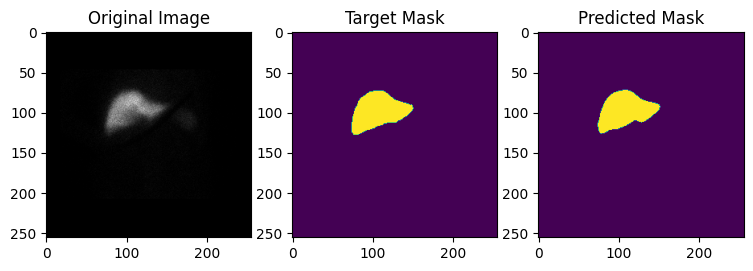

In [16]:
sample_idx = 0
image, target = test_dataset[sample_idx]
thresold = 0.8
preds = F.sigmoid(model(image.unsqueeze(0).to(DEVICE))).squeeze(0)
binary_preds = (preds > thresold)
fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[0].set_title("Original Image") 
ax[1].imshow(target.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[1].set_title("Target Mask")
ax[2].imshow(binary_preds.cpu().numpy()[0])
ax[2].set_title("Predicted Mask") 